In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.datasets import make_blobs

%watermark -a 'Ethen' -d -t -v -p numpy,matplotlib,sklearn

Ethen 2017-09-12 15:32:34 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
matplotlib 2.0.0
sklearn 0.18.1


# Support Vector Machine (SVM)

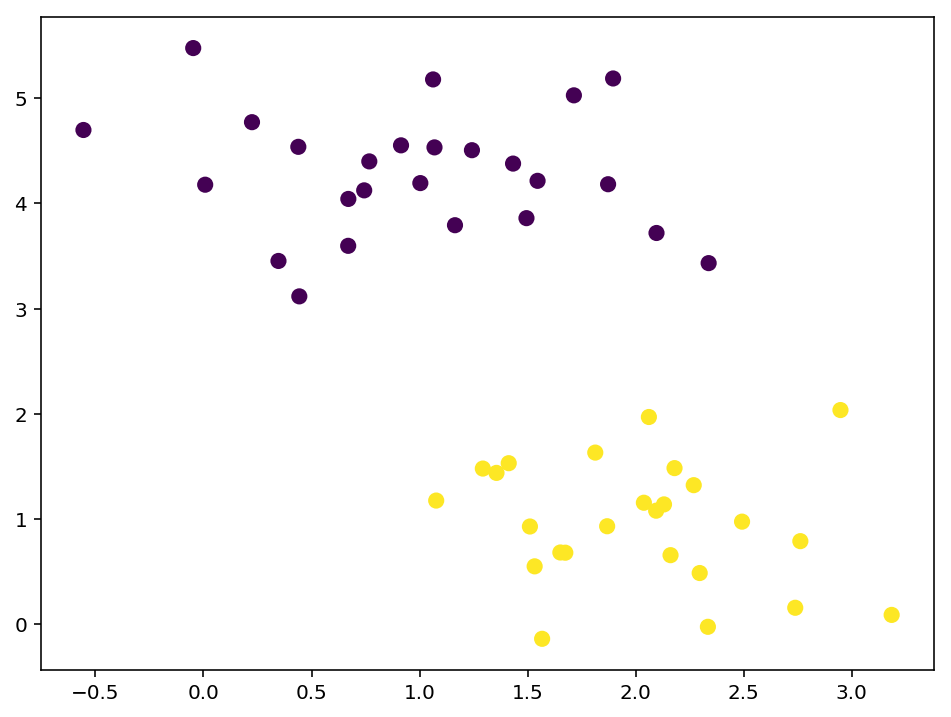

In [14]:
plt.rcParams['figure.figsize'] = 8, 6

X, y = make_blobs(
    n_samples = 50, centers = 2, random_state = 0, cluster_std = 0.60)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)
plt.show()

Given the dataset, we wish to come up with an algorithm that separates the two classes and finding a line (in higher dimension, the line is more often referred to as a hyperplane) that passes between the two classes seems like a good choice, but immediately we realize that there's more than one line that can perfectly separate the two classes (See figure below).


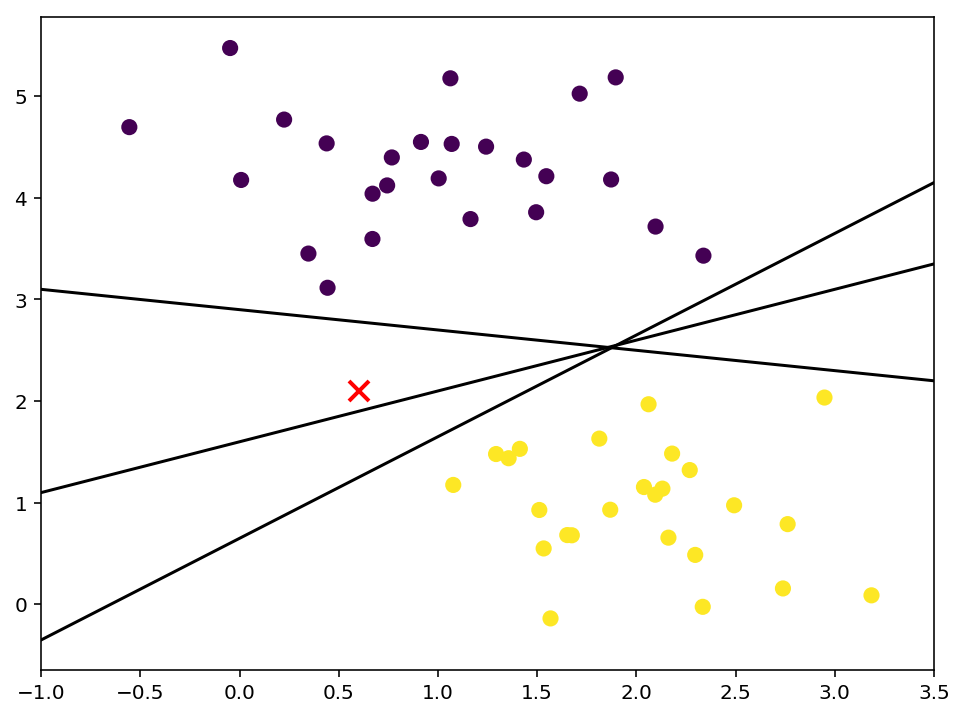

In [18]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)
plt.plot([0.6], [2.1], 'x', color = 'red', markeredgewidth = 2, markersize = 10)

# three possible candidates for a line that
# separates the two classes
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

These are three valid separating hyperplanes which all successfully separate the samples from the two classes. Depending on which we choose, however, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Thus, we need to think a bit deeper and find a line that's most suitable for the job.

**Support Vector Machines (SVM)** offers one way to find the most preferable line base on the training data we provide. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look like:

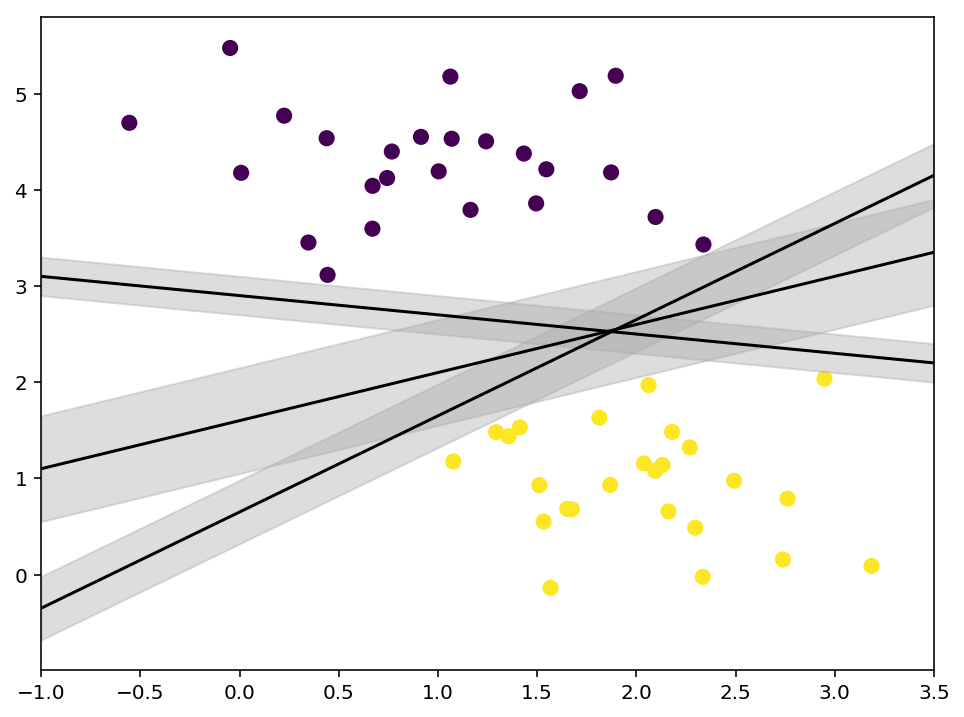

In [19]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)

# add a margin to the three candidates
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor = 'none',
                     color = '#AAAAAA', alpha = 0.4)

plt.xlim(-1, 3.5)
plt.show()

In SVM, the line that maximizes this margin is the one we will choose as the optimal model. In other words, the objective is to choose a line that's as far as possible from the data points of both classes to minimize the chance of making a mistake. Now that we understand SVM's goal is to find the hyperplane which maximizes the margin. The next question is, how do we calculate this margin?

Linear SVM classifier predicts the new class of a new observation $x$ by plugging it in to the hyperplane/decision function: $\mathbf{w}\cdot\mathbf{x} + b = 0$ if the result is positive than the predicted class, $\hat{y}$, will be the positive class and vice versa:

\begin{align}
\hat{y} =
\begin{cases}
   1 \text{ if } \mathbf{w}\cdot\mathbf{x} + b \geq 0 \\
   0 \text{ if } \mathbf{w}\cdot\mathbf{x} + b < 0
\end{cases}
\end{align}

Apart from the hyperplane $\mathbf{w}\cdot\mathbf{x} + b = 0$ that separates the data, from the plot above, we can see that to construct the margin we also have the two hyperplane that separates our data $H_0$ and $H_1$, which can be denoted as:

\begin{align}
H_0 &: \mathbf{w}\cdot\mathbf{x} + b = -\delta \\
H_1 &: \mathbf{w}\cdot\mathbf{x} + b = \delta
\end{align}

However, here the variable $\delta$ is not necessary. So we can safely set it to 1 to simplify the problem (more on this later), hence we end up with:

\begin{align}
H_0 &: \mathbf{w}\cdot\mathbf{x} + b = -1 \\
H_1 &: \mathbf{w}\cdot\mathbf{x} + b = 1
\end{align}

Recall that the goal of SVM is to find the hyperplane that maximizes the margin, and this is equivalent to maximizing the distance between the two hyperplane $H_0$ and $H_1$. To make this a bit concrete, let's look at the diagram below:

<img src="img/margin1.png" width="55%" height="55%">

Let's assume that $x_0$ is a point on $H_0$, We will use $m$ to denote the perpendicular distance from $x_0$ to the hyperplane $H_1$. As $x_0$ is on $H_0$, $m$ is the distance between the two hyperplanes and this is by definition the margin that we're interested in.

The initial thought might be, if we add $m$ to $x_0$ we will get another point, and this point will be on the other hyperplane and we can then compute the distance between the two points to obtain the margin. But it does not work, because $m$ is a scalar, and $x_0$ is a vector and adding a scalar with a vector is not possible. However, we know that adding two vectors is possible, so if we transform $m$ into a vector we will be able to do an addition. In other words, our temporary goal is to complete the equation $\textbf{z}_0 = \textbf{x}_0 + \textbf{k}$, where $\textbf{z}_0$ is the point on the $H_1$ hyperplane and $\textbf{k}$ is the vector that would complete the vector addition:

<img src="img/margin2.png" width="55%" height="55%">

To complete this equation, we know our vector $\textbf{k}$ needs to have two properties:

- Have a magnitude of $m$, the margin.
- Be perpendicular to the hyperplane $H_1$

Fortunately, given that $H_1 : \mathbf{w}\cdot\mathbf{x} + b = 1$ we already know our vector $\mathbf{w}$ is perpendicular to $H_1$

<img src="img/margin3.png" width="55%" height="55%">

Now, we can first scale $\mathbf{w}$ back to a unit vector and multiply it with $m$ to get our targeted vector $\textbf{k}$

\begin{align}
\textbf{k} &= m\frac{\textbf{w}}{\| \textbf{w} \|}
\end{align}

Given this information we can now derive the formula for our margin $m$. Given that $\textbf{z}_0$ is on the hyperplane $H_1 : \mathbf{w}\cdot\mathbf{x} + b = 1$ and $\textbf{x}_0$ is on the hyperplane $H_0 : \mathbf{w}\cdot\mathbf{x} + b = -1$:

\begin{align}
\textbf{w} \cdot \textbf{z}_0 + b = 1 
&=> \textbf{w} \cdot (\textbf{x}_0 + \textbf{k}) + b = 1 \\
&=> \textbf{w} \cdot (\textbf{x}_0 + m\frac{\textbf{w}}{\| \textbf{w} \|}) + b = 1 \\
&=> \textbf{w} \cdot \textbf{x}_0 + m\frac{\textbf{w} \cdot \textbf{w}}{\| \textbf{w} \|} + b = 1 \\
&=> \textbf{w} \cdot \textbf{x}_0 + m\| \textbf{w} \| + b = 1 \\
&=> \textbf{w}\cdot\textbf{x}_0 + b = 1 - m\|\textbf{w}\| \\
&=> -1= 1 - m\| \textbf{w} \| \\
&=> m = \frac{2}{\|\textbf{w}\|}
\end{align}

Looking at this formula for computing the margin, there's two things that we should be aware of:

1. Recall that a while ago, we said that for the hyperplanes, the parameter $\delta$ can be safely set to 1. Judging from the formula, we can see that the exact value of $\delta$ is in some sense meaningless as it is a multiplicative constant to the margin, and our denominator can simply shrink or stretch accordingly.
2. We see that the only variable we can change is the norm of $\textbf{w}$, $\|\textbf{w}\|$. And hopefully, it's intuitive that maximizing the margin is equivalent to minimizing $\|\textbf{w}\|$.

In [6]:
# the hinge loss and dual parameter will be explained shortly
svm = LinearSVC(loss = 'hinge', dual = True)
svm.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [7]:
decision_function = X.dot(svm.coef_.T) + svm.intercept_

In [8]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [9]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline((
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
))
scaled_svm_clf2 = Pipeline((
    ("scaler", scaler),
    ("linear_svc", svm_clf2),
))

svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
))

svm_clf.fit(X, y)
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(steps=(('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))))

In [10]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [11]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

[4, 6, 0.8, 2.8]

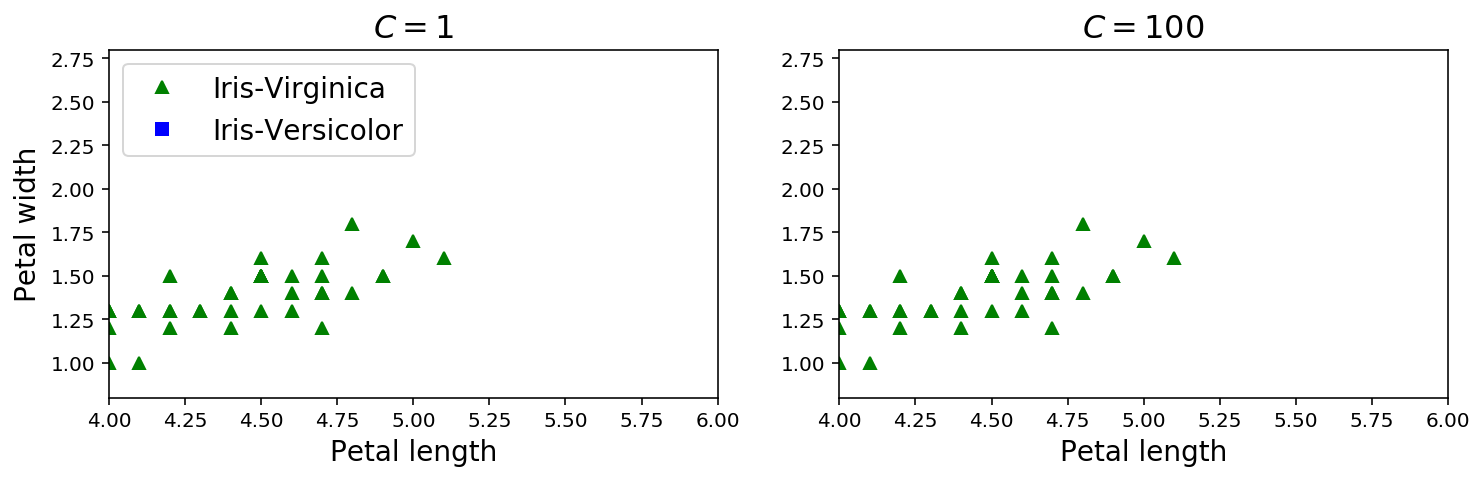

In [12]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

# Reference

- [Blog: SVM Tutorial](https://www.svm-tutorial.com/)
- [Notebook: In-Depth: Support Vector Machines](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb)